###  Covert the longitudinal blood pressure measurnments into a proper time series

In [42]:
import pandas as pd 
import sys 

# Load the data with tab seperator  
df = pd.read_csv("patient_longitudinal.csv", sep='\t')

#  Convert `visit_date` to datetime and set as index
df['visit_date'] = pd.to_datetime(df['visit_date'], format='%Y-%m-%d')
df.set_index('visit_date', inplace=True)

# Handle duplicates by grouping with visit_date and applying mean aggregation
df = df[~df.index.duplicated(keep='first')].groupby(level=0).mean()

# Handle missing values by interpolating missing values 
df['bp_systolic'] = df['bp_systolic'].interpolate()

# Convert to pandas Series for a single time series of blood pressure measurements
blood_pressure_series = pd.Series(df["bp_systolic"])



### Plot the new longitudinal blood pressure time series

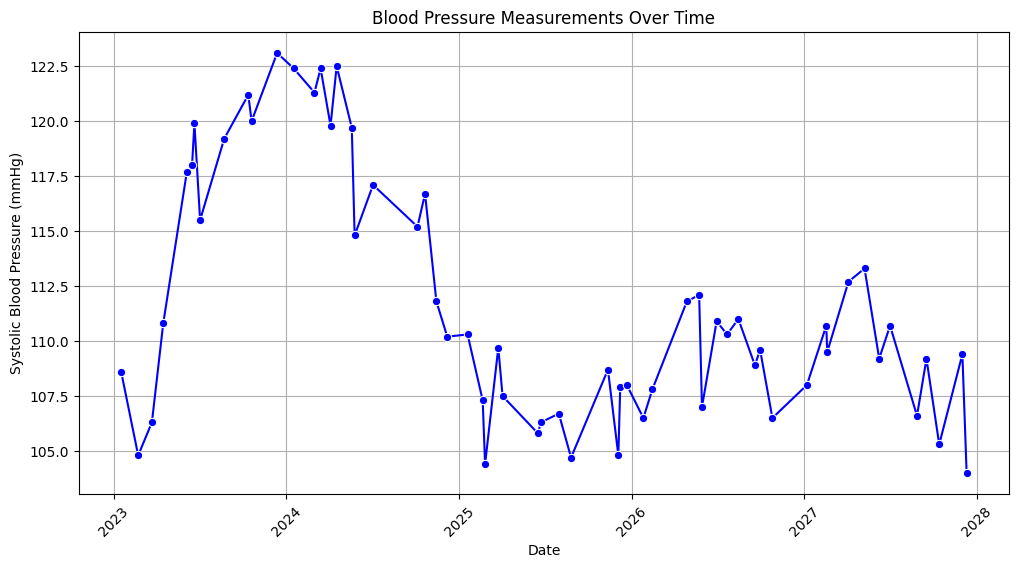

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the Series back to a DataFrame for Seaborn
df_plot = blood_pressure_series.reset_index()

# Plotting the time series with Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x='visit_date', y='bp_systolic', marker='o', color='b')
plt.title('Blood Pressure Measurements Over Time')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.show()


###  Analyze blood pressure trends:
   - Resample the data to monthly frequency using mean aggregation
   - Calculate 3-month moving averages to smooth out short-term fluctuations

/var/folders/63/klpq6sss15lb697997qxym8m0000gn/T/ipykernel_28785/354375857.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_bp = blood_pressure_series.resample('M').mean()


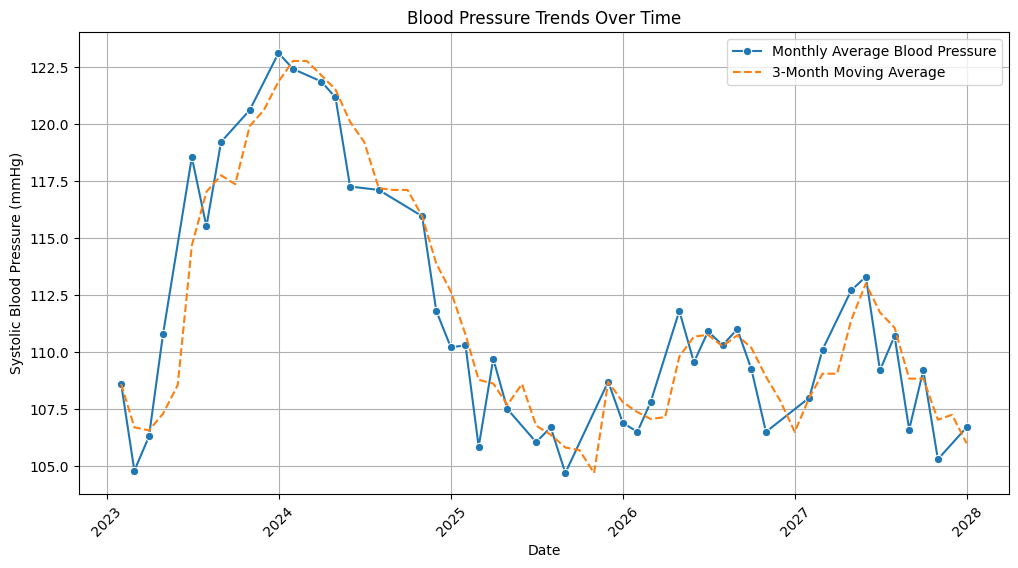

In [3]:
# Resample to monthly frequency
monthly_bp = blood_pressure_series.resample('M').mean()

# Calculate a 3-month moving average
smoothed_bp = monthly_bp.rolling(window=3, min_periods=1).mean()

# Combine both series into a DataFrame for easier plotting with Seaborn
df_plot = pd.DataFrame({
    'Monthly Average': monthly_bp,
    '3-Month Moving Average': smoothed_bp
}).reset_index()

# Plot using Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x='visit_date', y='Monthly Average', label='Monthly Average Blood Pressure', marker='o')
sns.lineplot(data=df_plot, x='visit_date', y='3-Month Moving Average', label='3-Month Moving Average', linestyle='--')

# Customizing the plot
plt.title('Blood Pressure Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.xticks(rotation=45)  # Rotate date labels for readability
plt.grid(True)
plt.legend()
plt.show()

### Analyze factors affecting baseline blood pressure

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      2.000     54.252      0.000     104.569     112.417
age            0.2840      0.023     12.551      0.000       0.240       0.328
bmi            0.2786      0.066      4.198      0.000       0.148       0.409
smoking        5.2412      0.698      7.512      0.000       3.872       6.610
diabetes       9.8732      0.742     13.307      0.000       8.417      11.329


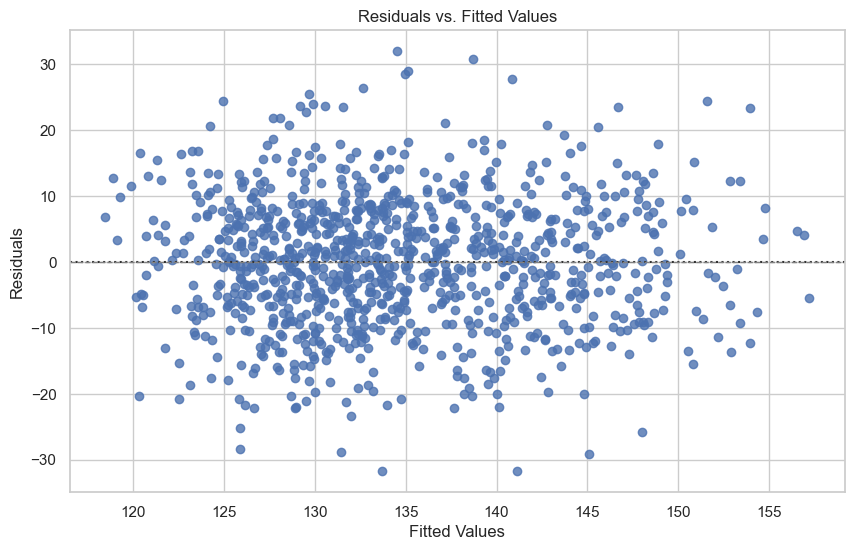

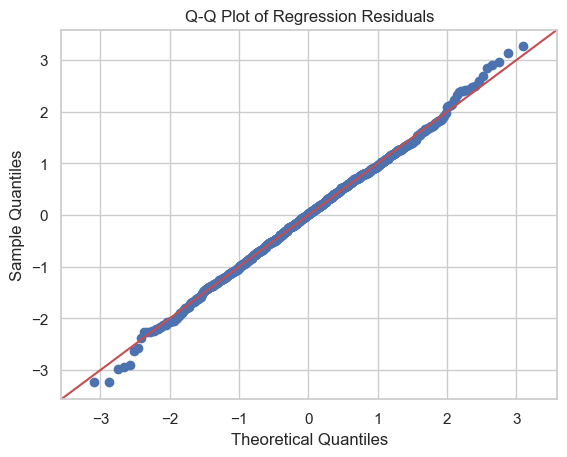

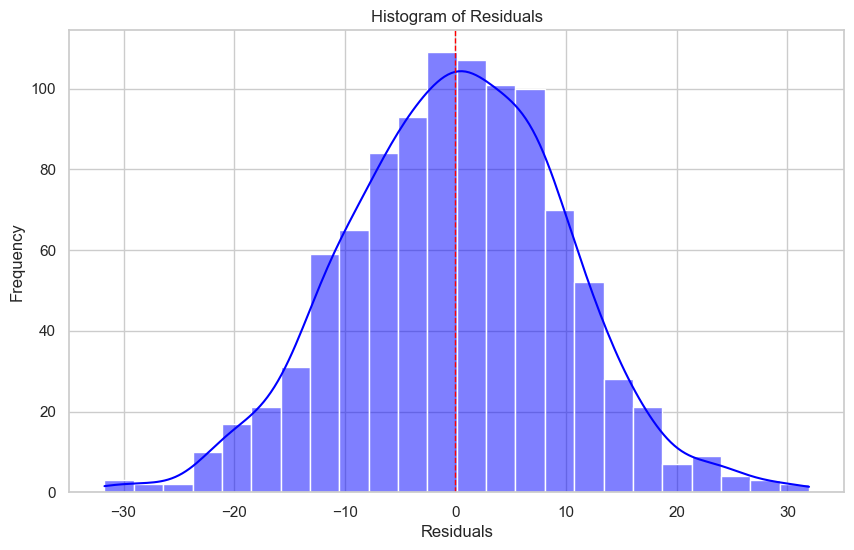

In [70]:
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 

# Load the baseline data with tab seperator  
hf = pd.read_csv("patient_baseline.csv", sep='\t')

# Set index as patient_id
hf.set_index('patient_id', inplace=True)

# Handle duplicates by grouping with visit_date and applying mean aggregation
hf = hf[~hf.index.duplicated(keep='first')]

#Handle missing values by interpolating missing values 
hf['bp_systolic'] = hf['bp_systolic'].interpolate()

# Create matrix with predictors and set y as bp_systolic
X = hf[["age", "bmi", "smoking", "diabetes"]]
y = hf["bp_systolic"]

# Add constant 
X_with_constant = sm.add_constant(X)

model = sm.OLS(y, X_with_constant)
results = model.fit()
print(results.summary().tables[1])

# Plot residuals vs. fitted values 
fitted_values = results.fittedvalues
residual_values = results.resid
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.residplot(x=fitted_values, y=residual_values, lowess=False)
plt.axhline(y=0, color='gray', linestyle='--', lw=1)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values')
plt.show()

# Plot Q-Q plot 
sm.qqplot(residual_values, line = '45', fit= "True")
plt.title('Q-Q Plot of Regression Residuals')
plt.show()

#Plot Histogram of residuals 
plt.figure(figsize=(10, 6))
sns.histplot(residual_values, kde=True, bins='auto', color='blue')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.show()

